In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.impute import SimpleImputer  #用于填补缺失值（均值，中值等）的类
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [6]:
dataset = load_boston()

In [7]:
#总共506*13= 6578个数据
X_full,Y_full = dataset.data,dataset.target
n_samples = X_full.shape[0] #样本的数量
n_features = X_full.shape[1] #标签的数量

In [8]:
#首先确定我们希望放入的缺失数据的比例 在这里我们的假设是50% 那总共要3289个数据缺失
rng = np.random.RandomState(0)
missing_rate = 0.5 #缺失数据的比例
n_missing_samples = int(np.floor(n_samples * n_features*missing_rate))
# np.floor向下取整，返回.0格式的浮点数

In [11]:
#所有数据要随机遍布在数据集的各行各列中，而一个缺失的数据会需要一个行索引和一个列索引
#如果能够创造一个数组，包含3289个分布在0-506之间的行索引，和3289个分布在0-13之间的列索引，那我们就可以利用
#这些索引来为数据中的任意的3289个位置赋空值
#然后我们用0，均值和随机森林来填写这些缺失值，然后查看回归的结果如何

missing_features = rng.randint(0,n_features,n_missing_samples)
#randint(下限，上限，n)请在上限和下限之间取n个整数

missing_samples = rng.randint(0,n_samples,n_missing_samples)

#missing_samples = rng.choice(dataset.data.shape[0],n_missing_samples,replace=False)
#我们现在采样了3289个数据，远远超过我们的样本量506，所以我们使用随机抽取的函数rangdint，但如果我们需要的数据量
#小于我们的样本量506，那我们可以采用np.random.choice来抽样，choice会随机抽取不重复的随机数
#因此可以帮助我们让数据更加分散，确保数据不会集中在一些行中

In [10]:
X_missing = X_full.copy()
Y_missint = Y_full.copy()

In [12]:
missing_features

array([ 6, 12, 12, ...,  6,  2, 11])

In [13]:
missing_samples

array([ 73, 414, 190, ..., 203, 469, 475])

In [15]:
X_missing[missing_samples,missing_features] = np.nan #附加空值

In [16]:
X_missing = pd.DataFrame(X_missing)
# 转换为DataFrame是为了后续方便各种操作，numpy对举证的运算速度很快，但是在索引功能上不如pandas方便

In [17]:
# 使用均值进行填补 SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan,strategy='mean') #缺失值是np.nan
X_missing_mean = imp_mean.fit_transform(X_missing) #训练后转出

In [23]:
pd.DataFrame(X_missing_mean).isnull().sum() #返回0说明没有缺失值了

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
dtype: int64

In [19]:
#使用0进行填补
imp_0 = SimpleImputer(missing_values=np.nan,strategy='contant',fill_value=0)
X_missing_0 = imp_mean.fit_transform(X_missing)

##### 使用随机森林填补缺失值

In [24]:
"""使用随机森林回归填补缺失值任何回归都是从特征矩阵中学习，然后求解连续型标签y的过程，之所以能够实现这个过程，
是因为回归算法认为，特征矩阵和标签之前存在着某种联系。实际上，标签和特征是可以相互转换的，比如说，在一个“用
地区，环境，附近学校数量”预测“房价”的问题中，我们既可以用“地区”，“环境”，“附近学校数量”的数据来预测
“房价”，也可以反过来，用“环境”，“附近学校数量”和“房价”来预测“地区”。而回归填补缺失值，正是利用了这
种思想。对于一个有n个特征的数据来说，其中特征T有缺失值，我们就把特征T当作标签，其他的n-1个特征和原本的标签组
成新的特征矩阵。那对于T来说，它没有缺失的部分，就是我们的Y_test，这部分数据既有标签也有特征，而它缺失的部分，
只有特征没有标签，就是我们需要预测的部分。特征T不缺失的值对应的其他n-1个特征 + 本来的标签：X_train特征T不缺失
的值：Y_train特征T缺失的值对应的其他n-1个特征 + 本来的标签：X_test特征T缺失的值：未知，我们需要预测的Y_test这
种做法，对于某一个特征大量缺失，其他特征却很完整的情况，非常适用。那如果数据中除了特征T之外，其他特征也有缺失
值怎么办？答案是遍历所有的特征，从缺失最少的开始进行填补（因为填补缺失最少的特征所需要的准确信息最少）。填补一
个特征时，先将其他特征的缺失值用0代替，每完成一次回归预测，就将预测值放到原本的特征矩阵中，再继续填补下一个特征
。每一次填补完毕，有缺失值的特征会减少一个，所以每次循环后，需要用0来填补的特征就越来越少。当进行到最后一个特征
时（这个特征应该是所有特征中缺失值最多的），已经没有任何的其他特征需要用0来进行填补了，而我们已经使用回归为其他
特征填补了大量有效信息，可以用来填补缺失最多的特征。遍历所有的特征后，数据就完整，不再有缺失值了。"""

'使用随机森林回归填补缺失值任何回归都是从特征矩阵中学习，然后求解连续型标签y的过程，之所以能够实现这个过程，\n是因为回归算法认为，特征矩阵和标签之前存在着某种联系。实际上，标签和特征是可以相互转换的，比如说，在一个“用\n地区，环境，附近学校数量”预测“房价”的问题中，我们既可以用“地区”，“环境”，“附近学校数量”的数据来预测\n“房价”，也可以反过来，用“环境”，“附近学校数量”和“房价”来预测“地区”。而回归填补缺失值，正是利用了这\n种思想。对于一个有n个特征的数据来说，其中特征T有缺失值，我们就把特征T当作标签，其他的n-1个特征和原本的标签组\n成新的特征矩阵。那对于T来说，它没有缺失的部分，就是我们的Y_test，这部分数据既有标签也有特征，而它缺失的部分，\n只有特征没有标签，就是我们需要预测的部分。特征T不缺失的值对应的其他n-1个特征 + 本来的标签：X_train特征T不缺失\n的值：Y_train特征T缺失的值对应的其他n-1个特征 + 本来的标签：X_test特征T缺失的值：未知，我们需要预测的Y_test这\n种做法，对于某一个特征大量缺失，其他特征却很完整的情况，非常适用。那如果数据中除了特征T之外，其他特征也有缺失\n值怎么办？答案是遍历所有的特征，从缺失最少的开始进行填补（因为填补缺失最少的特征所需要的准确信息最少）。填补一\n个特征时，先将其他特征的缺失值用0代替，每完成一次回归预测，就将预测值放到原本的特征矩阵中，再继续填补下一个特征\n。每一次填补完毕，有缺失值的特征会减少一个，所以每次循环后，需要用0来填补的特征就越来越少。当进行到最后一个特征\n时（这个特征应该是所有特征中缺失值最多的），已经没有任何的其他特征需要用0来进行填补了，而我们已经使用回归为其他\n特征填补了大量有效信息，可以用来填补缺失最多的特征。遍历所有的特征后，数据就完整，不再有缺失值了。'

In [26]:
X_missing_reg = X_missing.copy()
sortindex = np.argsort(X_missing_reg.isnull().sum(axis=0)).values  #找出数据集中，缺失值从小到大排列的特征们的顺序
#argsort返回的是从小到大排序的顺序所对应的索引

In [30]:
for i in sortindex:
    #构建我们的新特矩阵(没有被选中去填充的特征+原始的标签)和新标签（被选中去填充的标签）
    df = X_missing_reg
    fillc = df.iloc[:,i] #新标签
    df = pd.concat([df.iloc[:,df.columns != i],pd.DataFrame(Y_full)],axis=1) #新特征矩阵
    
    #在新特征矩阵中，对含有特征值的列，进行0的填补
    df_0 = SimpleImputer(missing_values=np.nan,strategy='constant',fill_value = 0).fit_transform(df)
    
    #找出我们的训练集和测试集
    Ytrain = fillc[fillc.notnull()] #在被选中要填充的特征中，现在是我们的标签，存在的那些值，非空值
    Ytest = fillc[fillc.isnull()]#是被选中的要填充的特征中，现在是我们的标签，不存在的那些值，是空值
    Xtrain = df_0[Ytrain.index,:]#在新特征矩阵上，被选出来的要填充的特征的非空值所对应的记录
    Xtest = df_0[Ytest.index,:]##新特征矩阵上，被选出来的药填充的那个特征的空值所对应的记录
    
    #用随机森林回归来填补缺失值
    rfc = RandomForestRegressor(n_estimators=100) #实例化
    rfc = rfc.fit(Xtrain,Ytrain)
    Ypredict = rfc.predict(Xtest)
    
    #将填补好的特征返回到我们的原始的特征矩阵中
    X_missing_reg.loc[X_missing_reg.iloc[:,i].isnull(),i] = Ypredict

In [34]:
# 对所有的数据进行建模 取得MSE结果
X = [X_full,X_missing_mean,X_missing_0,X_missing_reg]

mse = []
std = []
for x in X:
    estimator = RandomForestRegressor(random_state=0,n_estimators=100)
    scores = cross_val_score(estimator,x,Y_full,scoring='neg_mean_squared_error',cv=5).mean()
    mse.append(scores * -1)

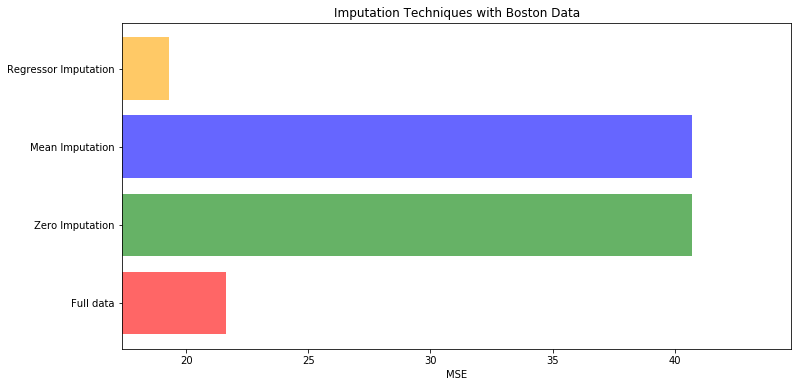

In [36]:
#用所给结果画出条形图
x_labels = ['Full data','Zero Imputation','Mean Imputation','Regressor Imputation']
colors = ['r', 'g', 'b', 'orange']
plt.figure(figsize=(12, 6)) #画出画布
ax = plt.subplot(111) #plt.subplot添加子图
for i in np.arange(len(mse)):
    ax.barh(i, mse[i],color=colors[i], alpha=0.6, align='center') # barh横向条形图 alpha粗度
ax.set_title('Imputation Techniques with Boston Data')
ax.set_xlim(left=np.min(mse) * 0.9,right=np.max(mse) * 1.1)
ax.set_yticks(np.arange(len(mse)))
ax.set_xlabel('MSE')
ax.set_yticklabels(x_labels)
plt.show()